In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [22]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
# regions = ['QL']

merge_df = pd.DataFrame(index = range(5866))

for each in regions:
    df = pd.read_csv('{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)

                        
#     for i in df.columns:
#         df[i] = df[i].fillna(method='ffill')
    
    merge_df = pd.concat([merge_df, df], axis = 1)


In [23]:
df = pd.read_csv('NSW_iso.csv')
df

,Date,Estimated_fire_area_NSW,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,mean_SoilWaterContent_NSW,mean_SolarRadiation_NSW,mean_Temperature_NSW,mean_WindSpeed_NSW,Vegetation_index_mean_NSW
0,2005-01-01,0.00000,0.0,0.044274,36.355567,0.170931,26.749389,27.341182,3.323550,0.348099
1,2005-01-02,0.00000,0.0,0.173879,38.699607,0.169551,27.047523,26.143898,3.030897,0.347922
2,2005-01-03,0.00000,0.0,3.011912,49.365152,0.179981,24.197452,27.408810,3.958409,0.347792
3,2005-01-04,8.68000,3.0,2.808620,57.095628,0.214293,22.617291,23.055527,4.841764,0.347685
4,2005-01-05,16.61125,8.0,0.157935,47.170735,0.203951,28.076835,22.425765,4.014080,0.347613
...,...,...,...,...,...,...,...,...,...,...
5861,2021-01-18,3.84000,3.0,1.030504,42.428072,0.173013,29.329009,23.170663,3.613584,0.389724
5862,2021-01-19,6.07500,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.390272
5863,2021-01-20,8.70000,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0.390813
5864,2021-01-21,40.88800,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0.391353


In [24]:
merge_df = merge_df.iloc[:5862, :].copy(deep=True)

In [25]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]
sqrt_count_regions = ['sqrt_Count_{}'.format(i) for i in regions]

for i,x in zip(fire_regions, count_regions):
    merge_df[i] = np.log1p(merge_df[i])
    merge_df[x] = np.log1p(merge_df[i])
    
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df['Date'] = pd.date_range(start = '2005-01-01', end = '2021-01-18')
merge_df.set_index('Date', inplace=True)

for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
# merge_df.fillna(0, inplace=True)



In [26]:
merge_df.fillna(0, inplace=True)

In [27]:
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)

In [28]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.000000,0.0,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.000000,0.0,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.00000,0.000000,0.0,0.0,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.000000,0.0,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.00000,0.000000,0.0,0.0,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.000000,0.0,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.00000,0.000000,0.0,0.0,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.000000,0.0,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.864808,2.283203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-14,0.000000,0.000000,4.616857,0.000000,0.0,0.000000,1.688249,0.000000,0.482932,41.060566,...,2.148687,2.822701,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.299326,1.292089
2021-01-15,1.782551,0.000000,4.097058,0.000000,0.0,0.000000,3.421327,1.023368,0.548561,37.711469,...,2.024119,2.583162,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.849683,2.255127
2021-01-16,2.498152,0.000000,4.359146,0.000000,0.0,0.000000,3.129321,1.252235,0.006825,40.095199,...,2.087857,2.705209,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.768989,2.106592


In [31]:
len(pd.date_range(start = '2021-01-19', end = '2021-02-28'))

41

In [32]:
train = merge_df[:'2020-12-01']
test = merge_df['2020-12-01':]

In [33]:
test.shape

(49, 77)

In [34]:

tf.keras.backend.clear_session()

In [35]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5814, 77)

In [36]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [37]:
n_steps_in, n_steps_out = 120, 41

In [38]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(5654, 41, 7)

In [39]:
X.shape

(5654, 120, 77)

In [40]:
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

In [41]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [42]:
y.shape

(5654, 287)

In [43]:
n_output

287

In [44]:
X_train, y_train = X[:-365,:,:], y[:-365,:]
X_valid, y_valid = X[-365:, :, :], y[-365:, :]

In [82]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])

In [83]:
history = model.fit(X_train, y_train, epochs = 100, callbacks = [lr_schedule], validation_data = (X_valid, y_valid))

Epoch 1/100
166/166 [==============================] - 14s 86ms/step - loss: 2.7819 - mae: 0.2725 - val_loss: 2.6514 - val_mae: 0.2541
Epoch 2/100
166/166 [==============================] - 12s 73ms/step - loss: 2.7776 - mae: 0.2725 - val_loss: 2.6459 - val_mae: 0.2541
Epoch 3/100
166/166 [==============================] - 12s 73ms/step - loss: 2.7742 - mae: 0.2724 - val_loss: 2.6409 - val_mae: 0.2541
Epoch 4/100
166/166 [==============================] - 12s 73ms/step - loss: 2.7714 - mae: 0.2724 - val_loss: 2.6408 - val_mae: 0.2542
Epoch 5/100
166/166 [==============================] - 12s 73ms/step - loss: 2.7658 - mae: 0.2724 - val_loss: 2.6354 - val_mae: 0.2542
Epoch 6/100
166/166 [==============================] - 12s 73ms/step - loss: 2.7628 - mae: 0.2724 - val_loss: 2.6287 - val_mae: 0.2542
Epoch 7/100
166/166 [==============================] - 12s 73ms/step - loss: 2.7612 - mae: 0.2723 - val_loss: 2.6257 - val_mae: 0.2543
Epoch 8/100
166/166 [==============================] - 

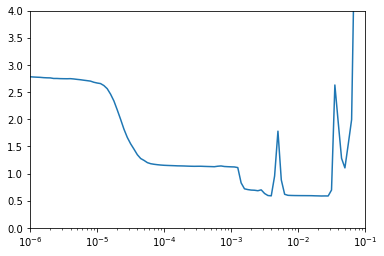

In [84]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 4]);

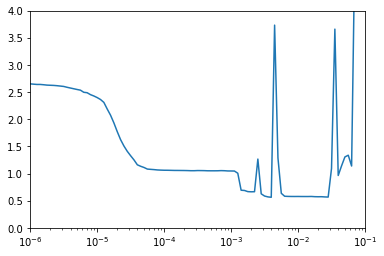

In [85]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, 4]);

In [88]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = 5e-5
                                    )

# tf.keras.losses.Poisson()
model.compile(optimizer, loss=tf.keras.losses.Poisson(), metrics = ['mae'])

In [127]:
history = model.fit(X_train, y_train, epochs = 1500, validation_data = (X_valid, y_valid))

Epoch 1/1500
166/166 [==============================] - 12s 73ms/step - loss: 0.8776 - mae: 0.1225 - val_loss: 0.8443 - val_mae: 0.1478
Epoch 2/1500
166/166 [==============================] - 12s 73ms/step - loss: 0.8816 - mae: 0.1287 - val_loss: 0.8391 - val_mae: 0.1467
Epoch 3/1500
166/166 [==============================] - 12s 73ms/step - loss: 0.8912 - mae: 0.1405 - val_loss: 0.8543 - val_mae: 0.1621
Epoch 4/1500
166/166 [==============================] - 12s 72ms/step - loss: 0.8860 - mae: 0.1340 - val_loss: 0.8435 - val_mae: 0.1531
Epoch 5/1500
166/166 [==============================] - 12s 73ms/step - loss: 0.8826 - mae: 0.1291 - val_loss: 0.8404 - val_mae: 0.1507
Epoch 6/1500
166/166 [==============================] - 12s 72ms/step - loss: 0.8812 - mae: 0.1272 - val_loss: 0.8400 - val_mae: 0.1495
Epoch 7/1500
166/166 [==============================] - 12s 73ms/step - loss: 0.8839 - mae: 0.1298 - val_loss: 0.8374 - val_mae: 0.1458
Epoch 8/1500
166/166 [==========================

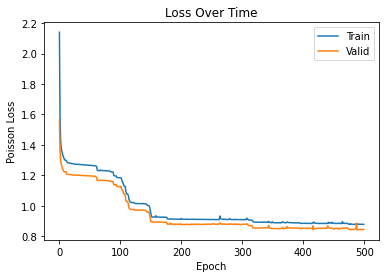

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [128]:
x_input = np.array(train.iloc[-120:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 287)

In [129]:
yhat_df = pd.DataFrame(yhat.reshape(41,7), index = test[:41].index, columns = fire_regions)

In [130]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-12-01,0.241699,0.381799,0.625525,0.139105,0.046489,0.049856,0.536554
2020-12-02,0.219225,0.378576,0.628681,0.138350,0.041767,0.062278,0.522339
2020-12-03,0.199370,0.398428,0.627225,0.089782,0.057969,0.038291,0.493208
2020-12-04,0.195150,0.366988,0.620704,0.112550,0.048247,0.094871,0.495716
2020-12-05,0.246134,0.382434,0.609080,0.156931,0.070794,0.084423,0.489639
2020-12-06,0.274258,0.365322,0.617231,0.150208,0.078194,0.060021,0.488311
2020-12-07,0.280773,0.356714,0.622429,0.186507,0.056223,0.073800,0.495185
2020-12-08,0.250277,0.349845,0.622018,0.163281,0.000000,0.041149,0.000000
2020-12-09,0.218929,0.320695,0.630074,0.131491,0.065443,0.043350,0.479250


In [131]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [132]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,2.067365,3.521126,5.172246,1.031316,0.312407,0.399216,4.851626,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-02,1.875136,3.491403,5.198336,1.025718,0.280672,0.498680,4.723089,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-03,1.705309,3.674491,5.186298,0.665642,0.389550,0.306607,4.459680,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-04,1.669205,3.384536,5.132381,0.834438,0.324215,0.759666,4.482357,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,2.105297,3.526982,5.036268,1.163476,0.475731,0.676001,4.427409,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06,2.345861,3.369169,5.103660,1.113636,0.525464,0.480612,4.415398,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-07,2.401586,3.289779,5.146646,1.382753,0.377814,0.590939,4.477557,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-08,2.140738,3.226428,5.143242,1.210552,0.000000,0.329492,0.000000,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-09,1.872602,2.957598,5.209859,0.974869,0.439775,0.347114,4.333473,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
test[:20]

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,0.000000,3.952441,5.482567,0.0,0.000000,0.000000,2.940440,0.000000,0.206143,39.675256,...,2.341488,3.201181,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.714771,2.008034
2020-12-02,0.000000,3.344980,5.793518,0.0,0.000000,0.000000,4.767425,0.000000,1.029015,42.126130,...,2.406973,3.331697,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.183443,2.890260
2020-12-03,1.071584,0.741937,5.230254,0.0,0.000000,0.000000,3.305879,0.728313,2.246048,46.104476,...,2.286975,3.093269,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.818208,2.196935
2020-12-04,1.798404,2.091041,6.379596,0.0,0.000000,1.526056,2.840247,1.029049,0.425724,35.201274,...,2.525786,3.570857,0.0,0.0,0.000000,0.000000,1.235337,1.189174,1.685303,1.954906
2020-12-05,0.693147,2.325325,6.154903,0.0,0.000000,0.000000,3.068983,0.526589,5.091297,61.585253,...,2.480908,3.480173,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.751851,2.075329
2020-12-06,0.000000,3.091529,6.331382,0.0,0.000000,0.000000,3.074117,0.000000,0.224302,43.849043,...,2.516224,3.551500,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.753316,2.077997
2020-12-07,1.321756,2.398804,5.910069,0.0,0.000000,0.000000,3.444595,0.842324,0.667009,47.497153,...,2.431063,3.379947,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.855962,2.266774
2020-12-08,3.069912,3.806151,6.018555,0.0,0.000000,0.000000,1.945910,1.403621,0.012537,42.210711,...,2.453274,3.424544,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.394959,1.449964
2020-12-09,1.996060,3.227637,5.620567,0.0,0.000000,0.000000,1.098612,1.097298,0.034324,39.774069,...,2.370773,3.259431,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.048147,0.902427


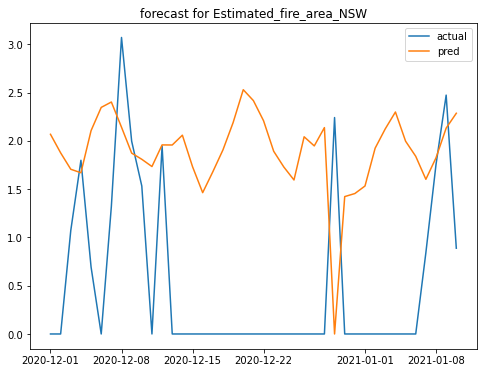

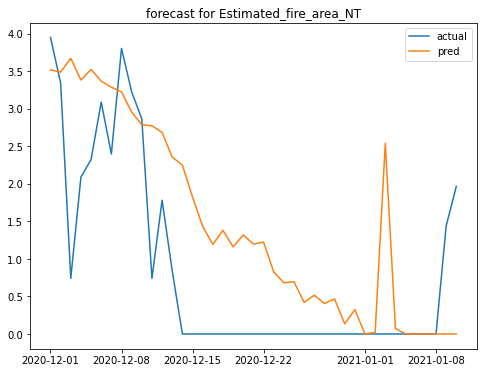

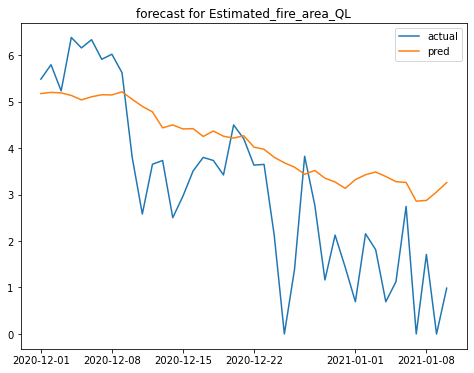

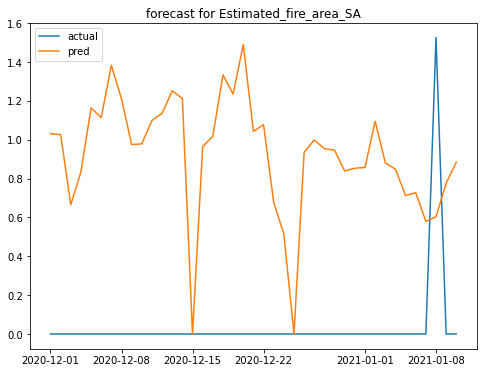

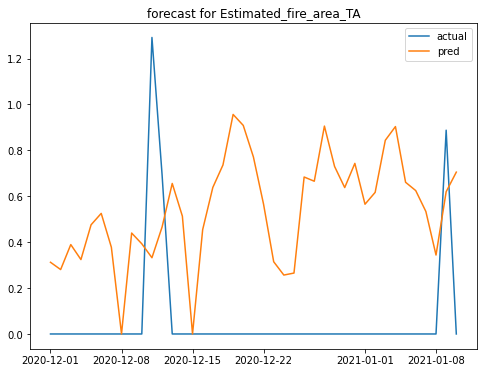

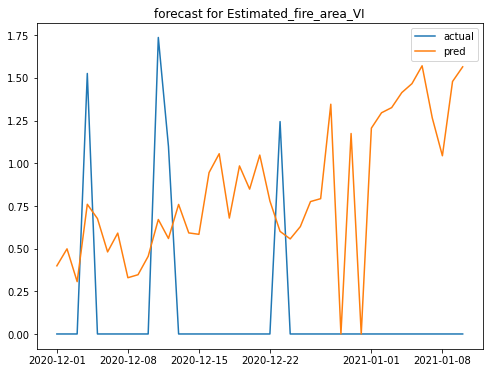

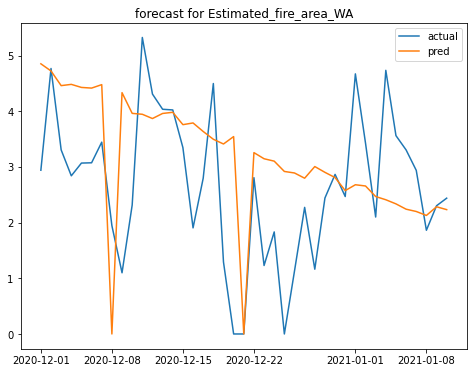

In [134]:
for i in fire_regions:

    plt.figure(figsize=(8,6))
    plt.plot(test[:41][i], label = 'actual')
    plt.plot(yhat_df[i], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [98]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.000000,0.0,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.000000,0.0,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.00000,0.000000,0.0,0.0,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.000000,0.0,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.00000,0.000000,0.0,0.0,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.000000,0.0,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.00000,0.000000,0.0,0.0,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.000000,0.0,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.864808,2.283203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-14,0.000000,0.000000,4.616857,0.000000,0.0,0.000000,1.688249,0.000000,0.482932,41.060566,...,2.148687,2.822701,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.299326,1.292089
2021-01-15,1.782551,0.000000,4.097058,0.000000,0.0,0.000000,3.421327,1.023368,0.548561,37.711469,...,2.024119,2.583162,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.849683,2.255127
2021-01-16,2.498152,0.000000,4.359146,0.000000,0.0,0.000000,3.129321,1.252235,0.006825,40.095199,...,2.087857,2.705209,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.768989,2.106592


In [99]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.000000,0.0,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.000000,0.0,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.00000,0.000000,0.0,0.0,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.000000,0.0,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.00000,0.000000,0.0,0.0,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.000000,0.0,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.00000,0.000000,0.0,0.0,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.000000,0.0,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.864808,2.283203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-14,0.000000,0.000000,4.616857,0.000000,0.0,0.000000,1.688249,0.000000,0.482932,41.060566,...,2.148687,2.822701,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.299326,1.292089
2021-01-15,1.782551,0.000000,4.097058,0.000000,0.0,0.000000,3.421327,1.023368,0.548561,37.711469,...,2.024119,2.583162,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.849683,2.255127
2021-01-16,2.498152,0.000000,4.359146,0.000000,0.0,0.000000,3.129321,1.252235,0.006825,40.095199,...,2.087857,2.705209,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.768989,2.106592


In [135]:
x_input = np.array(merge_df.iloc[-120:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 287)

In [136]:
yhat_df = pd.DataFrame(yhat.reshape(41,7), index = pd.date_range(start = '2021-01-19', end = '2021-02-28'), columns = fire_regions)

In [137]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
2021-01-19,0.193033,0.000000,0.428407,0.069835,0.042413,0.008520,0.260779
2021-01-20,0.269403,0.000000,0.442916,0.152713,0.070105,0.030892,0.299044
2021-01-21,0.272797,0.000000,0.444755,0.133096,0.088335,0.053835,0.267353
2021-01-22,0.232267,0.000000,0.466586,0.080810,0.040147,0.117704,0.245209
2021-01-23,0.148116,0.000000,0.392015,0.000000,0.045265,0.095956,0.242430
2021-01-24,0.110927,0.000000,0.371446,0.015871,0.001994,0.059000,0.199213
2021-01-25,0.134842,0.000000,0.386490,0.000000,0.000000,0.064644,0.187802
2021-01-26,0.205553,0.000000,0.376992,0.077685,0.000000,0.086814,0.000000
2021-01-27,0.303972,0.000000,0.367545,0.176774,0.108000,0.098413,0.254661
2021-01-28,0.310614,0.000000,0.424337,0.184998,0.115292,0.111951,0.284952


In [138]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [139]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
2021-01-19,1.651104,0.00000,3.542342,0.517752,0.285014,0.068220,2.358012,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-20,2.304332,0.00000,3.662314,1.132204,0.471105,0.247362,2.704013,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-21,2.333362,0.00000,3.677517,0.986769,0.593607,0.431076,2.417457,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-22,1.986690,0.00000,3.858033,0.599121,0.269788,0.942494,2.217227,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-23,1.266905,0.00000,3.241434,0.000000,0.304180,0.768348,2.192101,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-24,0.948812,0.00000,3.071353,0.117663,0.013398,0.472435,1.801325,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-25,1.153370,0.00000,3.195752,0.000000,0.000000,0.517627,1.698141,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-26,1.758188,0.00000,3.117214,0.575953,0.000000,0.695147,0.000000,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-27,2.600015,0.00000,3.039101,1.310589,0.725757,0.788024,2.302693,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-28,2.656830,0.00000,3.508688,1.371565,0.774758,0.896430,2.576591,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
submission = yhat_df['2021-02-01':'2021-02-28'][fire_regions]

In [151]:
submission.reset_index()

,index,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
0,2021-02-01,1.575605,0.00000,2.558930,0.178822,0.621008,0.524268,1.769832
1,2021-02-02,2.393086,0.00000,2.212950,0.000000,0.161249,0.696401,2.274033
2,2021-02-03,2.511116,0.00000,2.117649,1.042714,0.861175,0.826633,2.272529
3,2021-02-04,2.464773,0.00000,2.196213,0.823575,0.731826,0.965264,2.546134
4,2021-02-05,2.325544,0.00000,2.090019,0.681191,0.255951,0.493730,2.362693
5,2021-02-06,1.408362,0.00000,1.508060,0.423335,0.207200,0.359335,1.916501
6,2021-02-07,1.171593,0.00000,1.549963,0.239165,0.670204,0.291380,1.400271
7,2021-02-08,1.172654,0.00000,1.034532,0.403790,0.630145,0.371930,0.000000
8,2021-02-09,2.319409,0.00000,1.284596,0.616433,0.997417,1.051928,1.785933
9,2021-02-10,2.477799,0.00000,0.986299,1.201744,1.220726,1.314958,2.128682


In [152]:
submission_df = pd.melt(submission.reset_index().rename(columns={'index':'Date'}), id_vars = 'Date')

In [153]:
submission_df.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission_df = pd.concat([submission_df[['Region']], submission_df[['Date']], submission_df['Estimated_fire_area']], axis = 1)

In [154]:
for i,x in zip(fire_regions, regions):
    submission_df['Region'].replace(to_replace = i, value = x, inplace=True)

In [155]:
submission_df['Date'] = submission_df['Date'].dt.strftime('%b-%d')

In [156]:
submission_df['Estimated_fire_area'] = np.exp(submission_df['Estimated_fire_area']) - 1
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Feb-01,3.833666
1,NSW,Feb-02,9.947227
2,NSW,Feb-03,11.318672
3,NSW,Feb-04,10.760811
4,NSW,Feb-05,9.232241
...,...,...,...
191,WA,Feb-24,1.544311
192,WA,Feb-25,2.099221
193,WA,Feb-26,1.501859
194,WA,Feb-27,0.940098


In [157]:
submission_df.to_csv('submissions/final_dcnn70.csv', index= False, header=True)

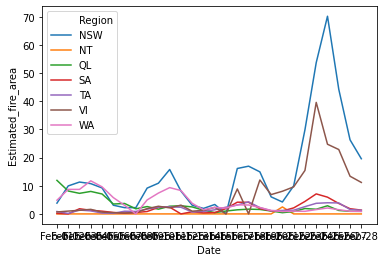

In [158]:
sns.lineplot(x = 'Date', y = 'Estimated_fire_area', hue = 'Region', data = submission_df)

In [335]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 38.90290729013289, 'mse': 22997.828797146867}}

In [349]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 37.61219740369566, 'mse': 23569.307062687083}}

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())

mse = mean_squared_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.63632714983575, 'mse': 23245.925698827847}}

In [242]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())

mse = mean_squared_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.181879816855414, 'mse': 22984.509506718343}}

In [102]:
_results

{'dcnn_log1p': {'mae': 31.10491818762526, 'mse': 23585.2343689479}}

In [68]:
submission = np.exp(yhat_df['2020-02':'2020-02-28'][fire_regions])-1

In [350]:
submission = yhat_df['2020-02':'2020-02-28'][fire_regions]

In [351]:
submission

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-02-01,4.872530,16.290304,76.914148,19.893977,0.000000,23.908127,76.084201
2020-02-02,4.025656,23.735369,90.589854,23.487532,11.047121,16.285827,61.459896
2020-02-03,18.506602,51.645641,80.972067,24.013329,5.385706,21.382732,119.708074
2020-02-04,10.369689,48.859950,76.366904,0.000000,6.302943,28.132637,45.278764
2020-02-05,10.350995,17.703335,79.200445,10.995348,5.655730,24.478431,44.870076
2020-02-06,13.065515,50.335522,75.509145,8.041986,4.197926,28.485465,53.816033
2020-02-07,19.344893,0.677286,67.839734,8.646607,0.000000,21.937465,46.250313
2020-02-08,11.768787,48.010576,68.704283,14.024737,0.000000,16.893945,19.844584
2020-02-09,7.614478,0.000000,65.091977,0.000000,6.379442,22.420182,20.294774


In [352]:
submission = pd.melt(submission.reset_index(), id_vars = 'Date')

In [353]:
submission

,Date,variable,value
0,2020-02-01,Estimated_fire_area_NSW,4.872530
1,2020-02-02,Estimated_fire_area_NSW,4.025656
2,2020-02-03,Estimated_fire_area_NSW,18.506602
3,2020-02-04,Estimated_fire_area_NSW,10.369689
4,2020-02-05,Estimated_fire_area_NSW,10.350995
...,...,...,...
191,2020-02-24,Estimated_fire_area_WA,52.541951
192,2020-02-25,Estimated_fire_area_WA,52.417119
193,2020-02-26,Estimated_fire_area_WA,47.690596
194,2020-02-27,Estimated_fire_area_WA,49.066346


In [354]:
submission.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [355]:
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [356]:
for i,x in zip(fire_regions, regions):
    submission['Region'].replace(to_replace = i, value = x, inplace=True)

In [357]:
submission

,Region,Date,Estimated_fire_area
0,NSW,2020-02-01,4.872530
1,NSW,2020-02-02,4.025656
2,NSW,2020-02-03,18.506602
3,NSW,2020-02-04,10.369689
4,NSW,2020-02-05,10.350995
...,...,...,...
191,WA,2020-02-24,52.541951
192,WA,2020-02-25,52.417119
193,WA,2020-02-26,47.690596
194,WA,2020-02-27,49.066346


In [358]:
submission.to_csv('Phase_1_sqrt_log4.csv', index= False,header=True)